In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2

**Load and normalize the data**

In [2]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
img_h, img_w = 224, 224

In [3]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

In [4]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [5]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [6]:
batch_size = 64
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **Resnet**

In [8]:
model_temp = 'resnet_pret'
grad = False
num_classes = 7
model_res = Model_functions.initialise_model(model_temp, num_classes, grad, use_pretrained=True)
model_res.to(device)

/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
input_size = (3, 224, 224)
summary(model_res, input_size, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

NameError: name 'model_res' is not defined

In [ ]:
start_time = time.time()

In [ ]:
epochs = 25
patience = 3
model_filename = 'resnet_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename)

  4%|▍         | 1/25 [01:47<43:05, 107.71s/it]

Epoch 1
Training Loss: 0.9171938994496139 
Training Accuracy: 66.63970231354149%
Validation Loss: 1.1113472946525849 
Validation Accuracy: 63.37162271477107%
Validation Loss Decreased(inf--->1.111347) 
Saving The Model


  8%|▊         | 2/25 [03:35<41:12, 107.50s/it]

Epoch 2
Training Loss: 0.6438775230007073 
Training Accuracy: 76.82413848891765%
Validation Loss: 1.0894894624493785 
Validation Accuracy: 64.60119721727875%
Validation Loss Decreased(1.111347--->1.089489) 
Saving The Model


 12%|█▏        | 3/25 [05:22<39:24, 107.46s/it]

Epoch 3
Training Loss: 0.5179364247266779 
Training Accuracy: 81.48357870894677%
Validation Loss: 0.6312322270931657 
Validation Accuracy: 76.85649571266785%
Validation Loss Decreased(1.089489--->0.631232) 
Saving The Model


 16%|█▌        | 4/25 [07:10<37:38, 107.53s/it]

Epoch 4
Training Loss: 0.4251333243146385 
Training Accuracy: 84.61414010677883%
Validation Loss: 0.431353152259109 
Validation Accuracy: 85.00242679178126%
Validation Loss Decreased(0.631232--->0.431353) 
Saving The Model


 20%|██        | 5/25 [08:57<35:49, 107.48s/it]

Epoch 5
Training Loss: 0.38507407707805485 
Training Accuracy: 86.10257239928814%
Validation Loss: 0.3911428036763496 
Validation Accuracy: 85.20465944022003%
Validation Loss Decreased(0.431353--->0.391143) 
Saving The Model


 24%|██▍       | 6/25 [10:44<34:01, 107.45s/it]

Epoch 6
Training Loss: 0.32362160585897487 
Training Accuracy: 88.16534541336354%
Validation Loss: 0.3881735242519182 
Validation Accuracy: 86.31289435366446%
Validation Loss Decreased(0.391143--->0.388174) 
Saving The Model


 28%|██▊       | 7/25 [12:54<34:27, 114.85s/it]

Epoch 7
Training Loss: 0.3078653782836555 
Training Accuracy: 89.09561559618184%
Validation Loss: 0.7469703287807936 
Validation Accuracy: 77.86765895486167%


 32%|███▏      | 8/25 [15:07<34:05, 120.34s/it]

Epoch 8
Training Loss: 0.28511709981050687 
Training Accuracy: 89.94499271962465%
Validation Loss: 0.3118028523611654 
Validation Accuracy: 88.48891765086556%
Validation Loss Decreased(0.388174--->0.311803) 
Saving The Model


 36%|███▌      | 9/25 [17:28<33:52, 127.04s/it]

Epoch 9
Training Loss: 0.22127404697623448 
Training Accuracy: 92.36369519495227%
Validation Loss: 0.4463228799364309 
Validation Accuracy: 85.89225044491182%


 40%|████      | 10/25 [19:54<33:12, 132.86s/it]

Epoch 10
Training Loss: 0.20505691346587593 
Training Accuracy: 93.07555411745672%
Validation Loss: 0.3304266017890468 
Validation Accuracy: 88.01164860055007%


 44%|████▍     | 11/25 [22:20<31:57, 136.94s/it]

Epoch 11
Training Loss: 0.2239721361163658 
Training Accuracy: 92.080569487138%
Validation Loss: 0.24139310050870955 
Validation Accuracy: 91.20692444588255%
Validation Loss Decreased(0.311803--->0.241393) 
Saving The Model


 48%|████▊     | 12/25 [24:50<30:29, 140.70s/it]

Epoch 12
Training Loss: 0.18744866469318106 
Training Accuracy: 93.4719301083967%
Validation Loss: 0.20361362094270816 
Validation Accuracy: 93.38294774308365%
Validation Loss Decreased(0.241393--->0.203614) 
Saving The Model


 52%|█████▏    | 13/25 [27:11<28:08, 140.72s/it]

Epoch 13
Training Loss: 0.15926299403546398 
Training Accuracy: 94.53971849215337%
Validation Loss: 0.17414922989213588 
Validation Accuracy: 93.85212748746157%
Validation Loss Decreased(0.203614--->0.174149) 
Saving The Model


 56%|█████▌    | 14/25 [29:27<25:34, 139.50s/it]

Epoch 14
Training Loss: 0.15434653458867184 
Training Accuracy: 94.72577252871703%
Validation Loss: 0.37981278170860305 
Validation Accuracy: 88.18961333117619%


 60%|██████    | 15/25 [31:45<23:08, 138.85s/it]

Epoch 15
Training Loss: 0.15695381739666475 
Training Accuracy: 94.57207571590358%
Validation Loss: 0.14608039158233202 
Validation Accuracy: 95.08170198996926%
Validation Loss Decreased(0.174149--->0.146080) 
Saving The Model


 64%|██████▍   | 16/25 [34:17<21:27, 143.02s/it]

Epoch 16
Training Loss: 0.1269991850173197 
Training Accuracy: 95.72075715903576%
Validation Loss: 0.18800392709480426 
Validation Accuracy: 93.39912635495874%


 68%|██████▊   | 17/25 [36:46<19:18, 144.80s/it]

Epoch 17
Training Loss: 0.14773171979300292 
Training Accuracy: 94.85520142371784%
Validation Loss: 0.1794911823667509 
Validation Accuracy: 93.70651998058567%


100%|██████████| 25/25 [38:33<00:00, 92.56s/it] 

Epoch 18
Training Loss: 0.12913771676494903 
Training Accuracy: 95.54279242840964%
Validation Loss: 0.1532220603398902 
Validation Accuracy: 95.46998867497169%


-------------------------------------------------------
Best models accuracy 95.29202394434557
-------------------------------------------------------


In [ ]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time:.2f} seconds")
elapsed_time = end_time - start_time

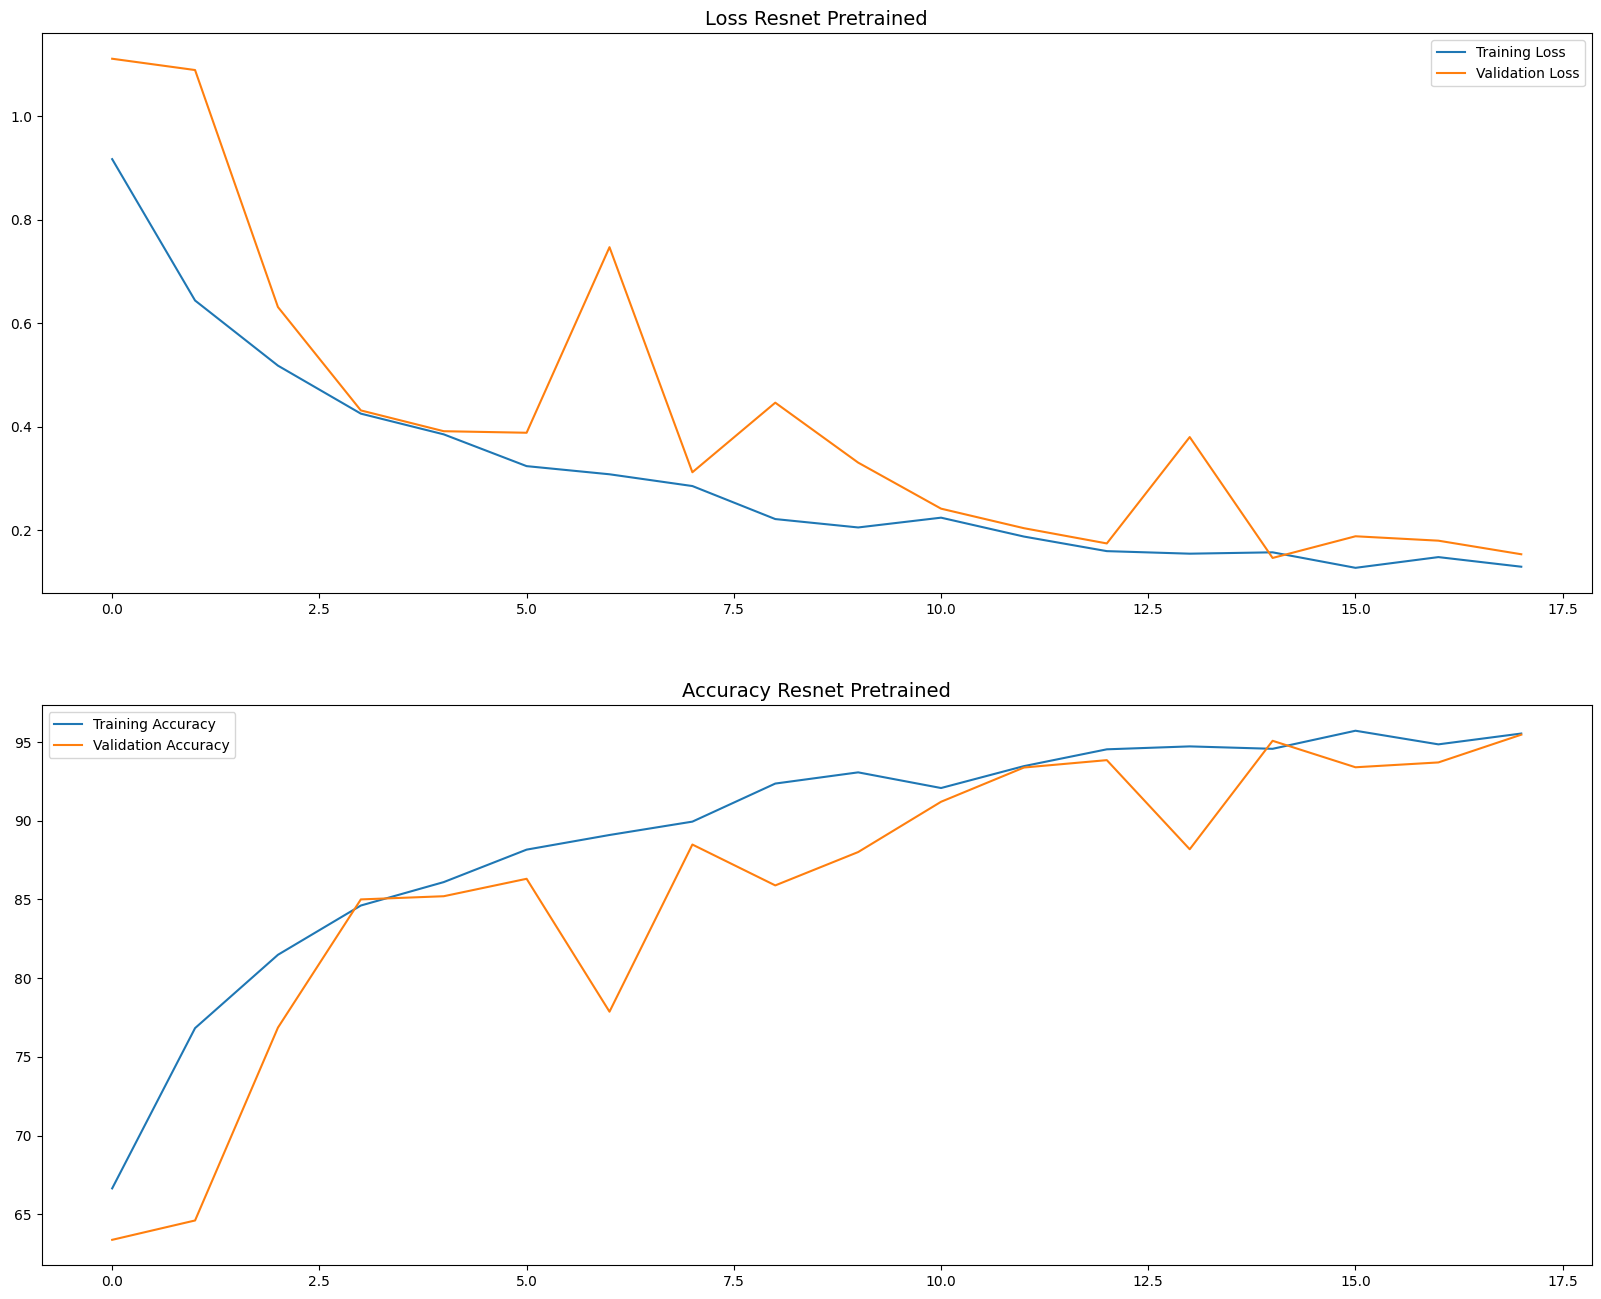

In [ ]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)  
fig2.legend()
plt.show()

In [ ]:
best_model_state = torch.load('resnet_pret.pth')
model_res.load_state_dict(best_model_state)
test_accuracy = Model_functions.test_model(model_res, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 94.96845170684355
-------------------------------------------------------


In [17]:
torch.cuda.empty_cache() 
import gc
gc.collect()

0

# **Densenet**

In [8]:
model_temp = 'densenet_pret'
num_classes = 7
feature_extract = False
model_des = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
# model_des = Model_functions.initialise_model(model_temp, num_classes, grad, use_pretrained=True)
model_des.to(device)

/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_des.parameters(), lr=1e-3)

In [10]:
input_size = (3, 224, 224)
summary(model_des, input_size, device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

In [11]:
start_time = time.time()

In [13]:
epochs = 25
patience = 3
model_filename = 'densenet.pth'
denset_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_des, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename)

  0%|          | 0/25 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacty of 7.75 GiB of which 10.25 MiB is free. Including non-PyTorch memory, this process has 7.64 GiB memory in use. Of the allocated memory 7.44 GiB is allocated by PyTorch, and 83.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF